In [1]:
from dem_stitcher.datasets import get_dem_tile_extents
import rasterio
from rasterio.errors import RasterioIOError
import concurrent.futures
from tqdm import tqdm
import geopandas as gpd

In [2]:
df_tiles = get_dem_tile_extents('glo_30')
df_tiles.head()

,geometry,tile_id,url,dem_name
0,"POLYGON ((-180.001 85.000, -180.001 86.000, -1...",Copernicus_DSM_COG_10_N85_00_W180_00_DEM,https://copernicus-dem-30m.s3.amazonaws.com/Co...,glo_30
1,"POLYGON ((-179.001 85.000, -179.001 86.000, -1...",Copernicus_DSM_COG_10_N85_00_W179_00_DEM,https://copernicus-dem-30m.s3.amazonaws.com/Co...,glo_30
2,"POLYGON ((-178.001 85.000, -178.001 86.000, -1...",Copernicus_DSM_COG_10_N85_00_W178_00_DEM,https://copernicus-dem-30m.s3.amazonaws.com/Co...,glo_30
3,"POLYGON ((-177.001 85.000, -177.001 86.000, -1...",Copernicus_DSM_COG_10_N85_00_W177_00_DEM,https://copernicus-dem-30m.s3.amazonaws.com/Co...,glo_30
4,"POLYGON ((-176.001 85.000, -176.001 86.000, -1...",Copernicus_DSM_COG_10_N85_00_W176_00_DEM,https://copernicus-dem-30m.s3.amazonaws.com/Co...,glo_30


So all tiles are accounted for in the geojson - though the urls might be empty!

<AxesSubplot:>

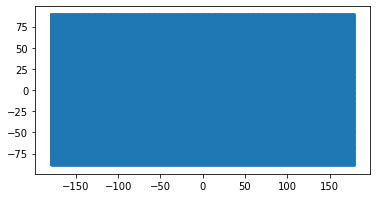

In [3]:
df_tiles.exterior.plot()

we should get a 404 response.

In [12]:
urls = df_tiles.url.tolist()
try:
    k = 0

    with rasterio.open(urls[k]) as ds:
        p = ds.profile
except Exception as e:
    print(e.__class__)
    print(e)

<class 'rasterio.errors.RasterioIOError'>
'/vsicurl/https://copernicus-dem-30m.s3.amazonaws.com/Copernicus_DSM_COG_10_N85_00_W180_00_DEM/Copernicus_DSM_COG_10_N85_00_W180_00_DEM.tif' does not exist in the file system, and is not recognized as a supported dataset name.


In [13]:
k = 2_000

with rasterio.open(urls[k]) as ds:
    p = ds.profile
p

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 720, 'height': 3600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.001388888888888889, 0.0, 19.999305555555555,
       0.0, -0.0002777777777777778, 81.00013888888888), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [14]:
def check_availability(url):
    try:
        with rasterio.open(url) as ds:
            ds.bounds
    except RasterioIOError:
        return False
    return True

In [15]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_geo = world.geometry.unary_union

<AxesSubplot:>

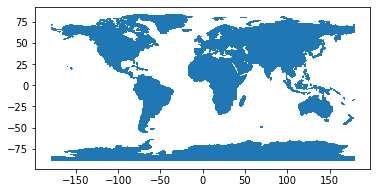

In [16]:
land = df_tiles.geometry.intersects(world_geo)
df_tiles_land = df_tiles[land]
df_tiles_land.plot()

In [17]:
df_tiles_land.shape, df_tiles.shape

((24163, 4), (64800, 4))

In [ ]:
urls = df_tiles.url.tolist()

# availability = list(map(check_availability, tqdm(urls[:10])))
with concurrent.futures.ThreadPoolExecutor(max_workers=30) as executor:
    availability = list(tqdm(executor.map(check_availability, urls), total=len(urls)))

  6%|▌         | 3888/64800 [42:02<70:37:44,  4.17s/it] 

In [ ]:
df_tiles['availability'] = availability
df_tiles.to_file('glo_30.geojson', driver='GeoJSON')